# Tokyo house price prediction
---
## Webアプリを作成した目的
賃貸を探すときに気に入った物件がお得なのか、少し割高なのか知りたいときがあるかと思います。  
そういった時にこのアプリケーションを利用すると、家賃の妥当性を定量的に知ることができます。
## WebアプリのURLと使用方法
### ① 下のURLにアクセス
http://54.250.166.173:5000/home  
### ② ログインフォームに下記を入力
Email：aaaa@gmail.com  
Passwrod：aaaa  
### ③ 例として、検索フォームに下記のURLをコピペして予測をクリック 
URL：https://www.homes.co.jp/chintai/b-1336110001797/  
上のURLはHOME'Sに掲載されているある物件です。（※すでに掲載が終了している可能性があります）
### ④ HOME'Sに掲載されている東京都内の好きな物件のURLを貼り付けて予測
HOME'SのURL：https://www.homes.co.jp/chintai/tokyo/list/  
現在は、事前にスクレイピングによって取得した物件（約16万件）のみ予測可能です。  
今後は任意のURLを貼り付けて予測できるように改良する予定です。
## データの取得方法
HOME'Sに掲載されている東京都の物件約16万件をスクレイピングによって取得しました。

# データの前処理とEDA
---
## The DATA

In [1]:
model_save = False

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import glob
sns.set()

p = Path('../data')
df_all = pd.concat([pd.read_csv(f, index_col=0) for f in p.glob('*.csv')], sort=True)

In [3]:
df_all.drop_duplicates(subset='url', keep='first', inplace=True)

In [4]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164716 entries, 0 to 34
Data columns (total 47 columns):
address                      164685 non-null object
air_conditioner              164716 non-null int64
auto_lock                    164716 non-null int64
balcony_space                164685 non-null object
bank                         159775 non-null object
conditions                   164684 non-null object
contract_period              139187 non-null object
daylight_direction           164685 non-null object
deposit                      164685 non-null object
deposit2                     164685 non-null object
eatting                      159775 non-null object
education                    159775 non-null object
equipments                   162071 non-null object
equipments2                  142073 non-null object
floor                        104790 non-null object
floor2                       164684 non-null object
floor_plan                   164685 non-null object
floor_space

In [5]:
df_all.head(5)

,address,air_conditioner,auto_lock,balcony_space,bank,conditions,contract_period,daylight_direction,deposit,deposit2,...,rent_all,security_deposit,separate,shopping,south,station_express_info,status,structure,traffic,url
0,東京都中野区新井5丁目,1,1,-,\n（株）りそな銀行 中野支店 新井薬師出張所\n中野上高田郵便局\n西武信用金庫 薬師駅前...,\n ...,2年間,南西,- / -,\n -,...,"8.7万円 ( 5,000円 )",8.7万円 / 無,1,\nローソンストア１００中野新井四丁目店\nｍｉｎｉピアゴ新井５丁目店\nあらいやくし薬局\...,0,西武新宿線 新井薬師前駅 徒歩4分普通準急急行通勤急行ＪＲ中央線 中野駅 徒歩18分普通快速...,空家,\n ...,\n西武新宿線 新井薬師前駅 徒歩4分\nＪＲ中央線 中野駅 徒歩18分\n\n通勤・通学駅...,https://www.homes.co.jp/chintai/b-1064980018577/
1,東京都墨田区東向島3丁目,1,1,-,\n東京東信用金庫 本店\n東向島一郵便局\n（株）三菱東京ＵＦＪ銀行 向島支店\n向島郵便...,\n 二人入居可\n ...,2年間,北西,- / -,\n ...,...,"8.5万円 ( 10,000円 )",無 / 1ヶ月,1,\nセブン－イレブン 墨田東向島４丁目店\nグルメシティー東向島駅前店\nあおぞら薬局\n柳...,0,東武伊勢崎線 曳舟駅 徒歩6分普通区間準急準急区間急行急行京成押上線 京成曳舟駅 徒歩7分普...,未完成,\n ...,\n東武伊勢崎線 曳舟駅 徒歩6分\n京成押上線 京成曳舟駅 徒歩7分\n東武伊勢崎線 東向...,https://www.homes.co.jp/chintai/b-1313570020198/
2,東京都墨田区東向島3丁目,1,1,-,\n東京東信用金庫 本店\n向島郵便局\n（株）三菱東京ＵＦＪ銀行 向島支店\n東向島一郵便...,\n ペット相談\n ...,2年間,北西,- / -,\n ...,...,"8.55万円 ( 10,000円 )",無 / 1ヶ月,1,\nローソン 墨田東向島二丁目店\nまいばすけっと 東武曳舟駅西店\nさつき薬局\n菊屋本店...,0,東武伊勢崎線 曳舟駅 徒歩6分普通区間準急準急区間急行急行京成押上線 京成曳舟駅 徒歩7分普...,未完成,\n ...,\n東武伊勢崎線 曳舟駅 徒歩6分\n京成押上線 京成曳舟駅 徒歩7分\n\n通勤・通学駅ま...,https://www.homes.co.jp/chintai/b-1171750025121/
3,東京都杉並区上荻2丁目,1,1,-,\n三井住友信託銀行（株） 荻窪支店\n杉並四面道郵便局\n（株）三井住友銀行 荻窪支店\n...,\n コンロ二口\n ...,2年間,東,- / -,\n ...,...,"9.9万円 ( 7,000円 )",1ヶ月 / 1ヶ月,1,\nファミリーマート 杉並上荻二丁目店\nウッディーワン\n（有）ステラ薬局\n井上茶舗\n...,0,ＪＲ中央線 荻窪駅 徒歩8分普通快速通勤快速通勤特別快速中央特快青梅特快,未完成,\n ...,\nＪＲ中央線 荻窪駅 徒歩8分\n\n通勤・通学駅までの経路・所要時間を調べる\n\n,https://www.homes.co.jp/chintai/b-37031260003000/
4,東京都杉並区上荻2丁目,1,1,-,\n三井住友信託銀行（株） 荻窪支店\n杉並四面道郵便局\n（株）三井住友銀行 荻窪支店\n...,\n ...,2年間,西,- / -,\n ...,...,"9.9万円 ( 7,000円 )",1ヶ月 / 1ヶ月,1,\nファミリーマート 杉並上荻二丁目店\nウッディーワン\n（有）ステラ薬局\n井上茶舗\n...,0,ＪＲ中央線 荻窪駅 徒歩8分普通快速通勤快速通勤特別快速中央特快青梅特快,未完成,\n ...,\nＪＲ中央線 荻窪駅 徒歩8分\n\n通勤・通学駅までの経路・所要時間を調べる\n\n,https://www.homes.co.jp/chintai/b-37031260003010/


## Data description
- `name` - 物件名
- `floor` - 階数
- `rent` - 家賃
- `rent_all` - 家賃（共益費）
- `security_deposit ` - 敷金・礼金
- `deposit` - 保証金
- `traffic` - 最寄り駅などの情報
- `address` - 住所
- `number_of_stations_10_min` - 徒歩10分以内の駅数
- `number_of_stations_all` - 近くにある全ての駅の数
- `station_express_info` - 近くの駅の停車する電車の情報（急行・快速など）
- `shopping` - 近くにあるショッピング施設
- `eatting`- 近くにある飲食店
- `education` - 近くにある教育施設
- `hospital`- 近くにある病院
- `bank` - 近くにある銀行
- `public_facility` - 近くにある公共施設
- `how_old` - 築年数
- `daylight_direction` - 採光面
- `floor_space` - 床面積
- `balcony_space` - バルコニーの面積
- `floor_plan` - 間取り
- `recomend_point` - おすすめポイント
- `contract_period` - 契約期間
- `renewal_fee` - 更新料
- `deposit2` - 保証金2
- `home_insurance` - 住宅保険
- `status` - 状態（空き家など）
- `conditions` - 条件
- `kichen` - キッチン等の情報
- `equipments` - 設備の情報
- `other` - その他の情報
- `url` - 物件のURL

## Data cleaning
EDAやモデルの学習をおこなうために、データクリーニングをします。  
具体的には、以下の処理をしました。
- target変数である`rent`が欠損している行は削除
- すべてobject型になっているので、家賃など数値として扱うものは整数型に変更

In [6]:
df_all.dropna(subset=['rent'], inplace=True)

In [7]:
# 共益費
df_all['service_fee'] = \
    df_all.apply(lambda row: row['rent_all'].lstrip(row['rent']).strip(' ()円').replace(',','').replace('-', '0'), axis=1).astype('int')
df_all.drop('rent_all', axis=1, inplace=True)

In [8]:
df_all['rent'] = df_all['rent'].apply(lambda x: float(x.rstrip('万円'))*10000).astype('int')

## EDA and sample statistics
データの特性を知り、特徴量エンジニアリングやモデルの選定の際に活かします。

### `rent`（家賃）の分布と統計量

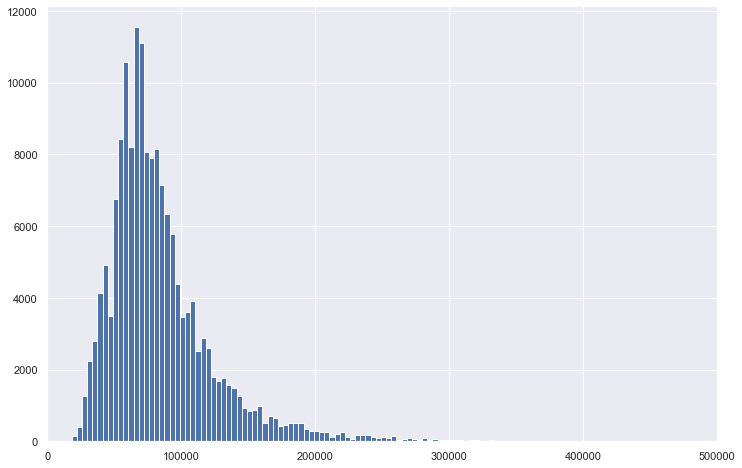

In [9]:
plt.figure(figsize=(12, 8))
plt.hist(df_all['rent'], bins=400)
plt.xlim(0, 500000)
plt.show()

In [10]:
df_all['rent'].describe()

count    1.646850e+05
mean     8.504018e+04
std      4.269391e+04
min      1.050000e+04
25%      6.000000e+04
50%      7.500000e+04
75%      9.900000e+04
max      1.550000e+06
Name: rent, dtype: float64

平均が91652円で、中央値が85000円。さすが東京、高いですね。。

### `service_fee`（共益費）の分布

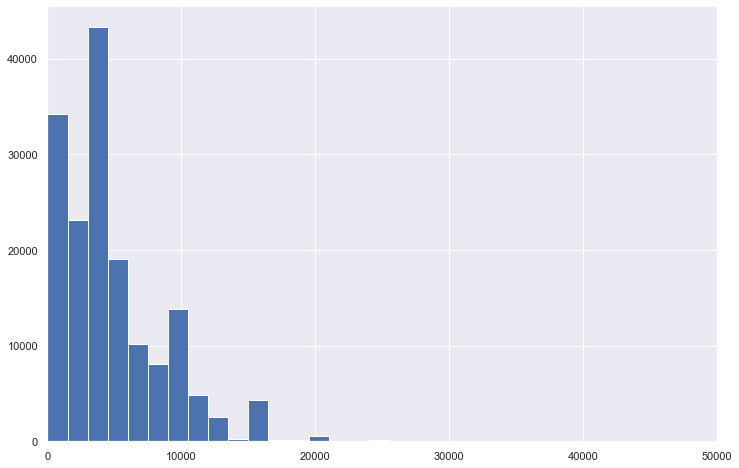

In [11]:
plt.figure(figsize=(12, 8))
plt.hist(df_all['service_fee'], bins=100)
plt.xlim(0, 50000)
plt.show()

In [12]:
df_all['service_fee'].describe()

count    164685.000000
mean       4407.091289
std        3983.448083
min           0.000000
25%        2000.000000
50%        3000.000000
75%        6000.000000
max      150000.000000
Name: service_fee, dtype: float64

共益費はあんまり綺麗な分布ではないですね。

### 目的変数の設定
このデータ分析では`rent`（家賃）と`service_fee`（共益費）を合計した金額を目的変数とします。  

In [13]:
# 目的変数
df_all['target'] = df_all['rent'] + df_all['service_fee']

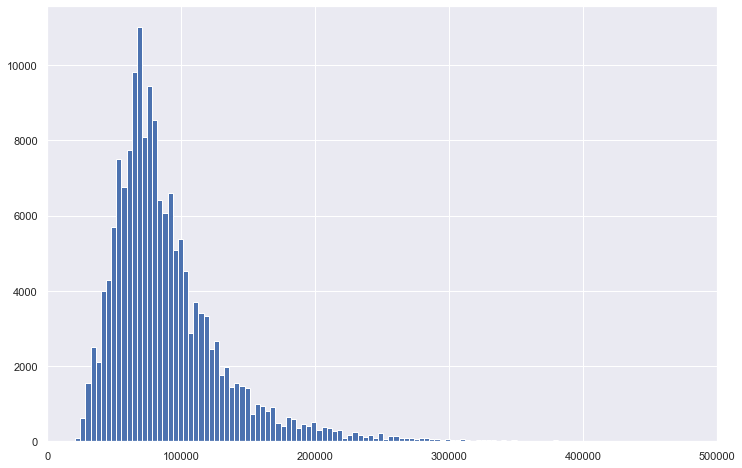

In [14]:
plt.figure(figsize=(12, 8))
plt.hist(df_all['target'], bins=400)
plt.xlim(0, 500000)
plt.show()

右裾が長い分布になっています。  
どれくらい正規分布からズレているか定量的に測ってみましょう。正規分布からのズレ具合を表す統計量として**歪度**があります。  
歪度は`Scipy`を使うことで簡単に計算できます。

In [15]:
import scipy

scipy.stats.skew(df_all['target'])

3.0333404245855253

歪度は1以上だとひどく歪んだ分布なので、東京都の家賃分布はかなり裾が長い分布と言えます。  
田舎だと家賃の幅が狭くて、歪度はもう少し低い値になりそうですね。  

損失関数によっては、このような正規分布から大きく外れた分布だと不都合が生じることがあるため、分布を正規分布に近い形に変換する必要があります。

### 目的変数の対数変換
目的変数を対数変換することで、分布を正規分布に近づけます。

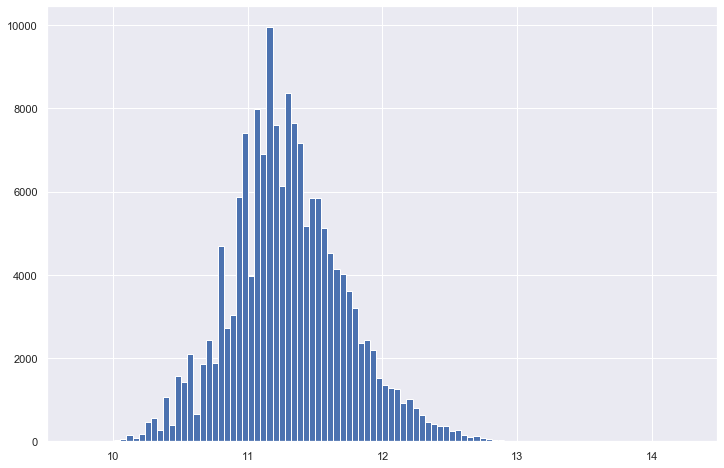

In [16]:
import numpy as np

plt.figure(figsize=(12, 8))
plt.hist(np.log1p(df_all['target']), bins=100)
plt.show()

見た目上、正規分布に近づいていることがわかります。定量的に確認するために、歪度をもう一度計算します。

In [17]:
scipy.stats.skew(np.log1p(df_all['target']))

0.3252554367056249

変換前の歪度が7.6だったので、対数変換によって正規分布に近づいていることが定量的に言えます。（正規分布だと歪度は0になります）

### 徒歩10分圏内の駅の数

In [18]:
df_all['number_of_stations_10_min'].unique()

array(['徒歩10分以内（1駅）', '徒歩10分以内（2駅）', '徒歩10分以内（0駅）', nan, '徒歩10分以内（4駅）',
       '徒歩10分以内（6駅）', '徒歩10分以内（3駅）', '徒歩10分以内（5駅）'], dtype=object)

駅数が欠損しているのは徒歩10分以内でしょうか。欠損している行を確認してみます。

In [19]:
df_all[df_all['number_of_stations_10_min'].isnull()].head(2)

,address,air_conditioner,auto_lock,balcony_space,bank,conditions,contract_period,daylight_direction,deposit,deposit2,...,separate,shopping,south,station_express_info,status,structure,traffic,url,service_fee,target
75,東京都府中市是政3丁目64-9,1,0,-,NaN,\n 二人入居可\n ...,2年間,南東,- / -,\n ...,...,1,NaN,0,ＪＲ南武線 府中本町駅 徒歩11分普通快速西武多摩川線 是政駅 徒歩12分普通,空家,\n ...,\nＪＲ南武線 府中本町駅 徒歩11分\n西武多摩川線 是政駅 徒歩12分\n\n通勤・通学...,https://www.homes.co.jp/chintai/b-1142840600220/,3000,77000
3,東京都文京区本駒込2丁目11,0,1,-,NaN,\n 二人入居可\n ...,2年間,南東,- / -,\n ...,...,0,NaN,0,都営三田線 千石駅 徒歩3分普通急行東京メトロ南北線 本駒込駅 徒歩9分普通,空家,\n ...,\n都営三田線 千石駅 徒歩3分\n東京メトロ南北線 本駒込駅 徒歩9分\n都営三田線白山駅...,https://www.homes.co.jp/chintai/b-1408470000244/,4000,162000


駅数が欠損していても、`traffic`から徒歩10分圏内の駅数は0じゃないことがわかります。

### `number_of_stations_10_min`と`number_of_stations_all`の欠損値の補完
欠損していない`traffic`から文字を抽出して、欠損している駅数を補完します。

In [20]:
df_all['traffic'].iloc[0]

'\n西武新宿線 新井薬師前駅 徒歩4分\nＪＲ中央線 中野駅 徒歩18分\n\n通勤・通学駅までの経路・所要時間を調べる\n\n'

上の文から10分以内の駅数、家の近くのすべての駅数を抽出できそうです。

In [21]:
import re

def count_10min_stations(col):
    stations = 0
    for i in col.splitlines():
        if 'バス' not in i:
            stations += len(re.findall('徒歩[0-9]分|徒歩10分', i))
    return stations

def count_near_stations(col):
    # ??駅 徒歩xx分という文の数をカウントして、駅数を求める。
    stations = len(re.findall('徒歩\d+分', col))
    try:
        # 他に??駅が利用可能という文から??駅を抽出
        stations += int(re.findall('に\d+駅', col)[0].strip('駅に'))
    except:
        # 他に??駅が利用可能という文が存在しない場合、配列外参照エラーがでるため例外処理しています。
        pass
    return stations

In [22]:
# 徒歩10分以内の駅数
# df_all['number_of_stations_10_min'] = df_all['traffic'].apply(lambda x: len(re.findall('徒歩[0-9]|10分', x))).astype('int')
df_all['number_of_stations_10_min'] = df_all['traffic'].apply(count_10min_stations).astype('int')
# 家の近くのすべての駅数
df_all['number_of_stations_all'] = df_all['traffic'].apply(count_near_stations).astype('int')

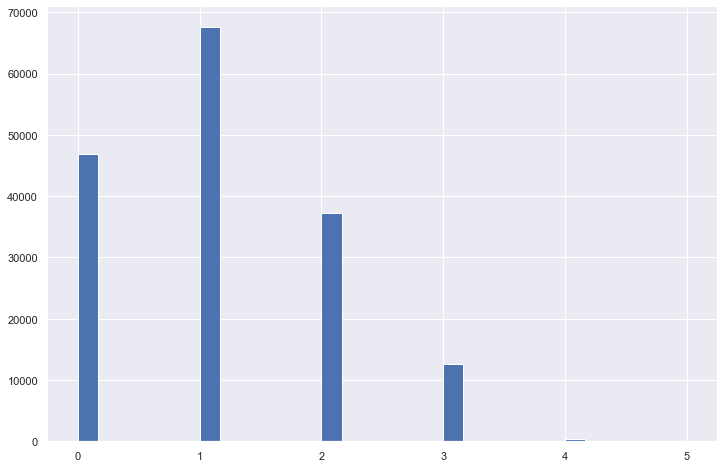

In [23]:
plt.figure(figsize=(12, 8))
plt.hist(df_all['number_of_stations_10_min'], bins=30)
plt.show()

In [24]:
df_all['number_of_stations_10_min'].value_counts()

1    67601
0    46957
2    37202
3    12612
4      311
5        2
Name: number_of_stations_10_min, dtype: int64

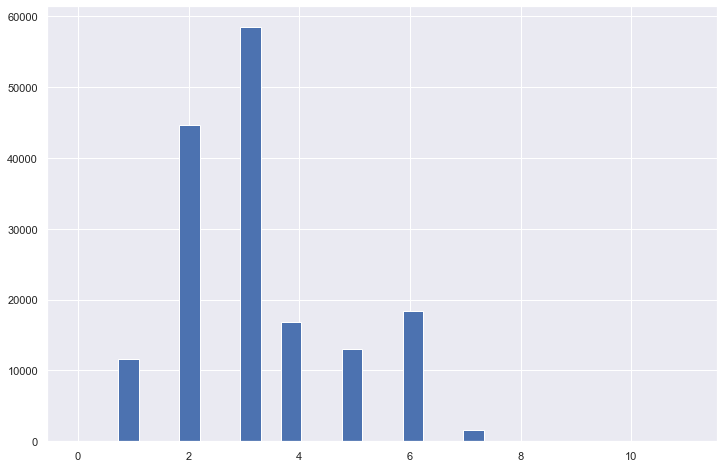

In [25]:
plt.figure(figsize=(12, 8))
plt.hist(df_all['number_of_stations_all'], bins=30)
plt.show()

In [26]:
df_all['number_of_stations_all'].value_counts()

3     58456
2     44683
6     18414
4     16810
5     13067
1     11577
7      1627
0        44
8         4
10        2
11        1
Name: number_of_stations_all, dtype: int64

### 1,2,3番目に近い駅を抽出

In [27]:
df_all.reset_index(drop=True, inplace=True)

In [28]:
first_near_station = [None for s in range(len(df_all))]
second_near_station = [None for s in range(len(df_all))]
third_near_station = [None for s in range(len(df_all))]

for index in df_all.index:
    stations_list = [s for s in df_all.loc[index, 'traffic'].splitlines() if ('通勤・通学駅' not in s) and ('他に' not in s) and s]
    for i, station in enumerate(stations_list):
        if i==0:
            # index=8の国立のように国立駅の駅が抜けている場合があるため例外処理
            try:
                first_near_station[index] = re.findall('.*駅', station)[0]
            except:
                first_near_station[index] = None
        elif i==1:
            try:
                second_near_station[index] = re.findall('.*駅', station)[0]
            except:
                second_near_station[index] = None
        elif i==2:
            try:
                third_near_station[index] = re.findall('.*駅', station)[0]
            except:
                third_near_station[index] = None

df_all['first_near_station'] = first_near_station
df_all['second_near_station'] = second_near_station
df_all['third_near_station'] = third_near_station

### 床面積

In [29]:
df_all['floor_space'] = df_all['floor_space'].apply(lambda x: x.rstrip('m²').replace(',', '')).astype('float')

### 築年数

In [30]:
# 築0年のときは新築と記載されているので、築0年に置き換える。
df_all['how_old'] = df_all['how_old'].apply(lambda x: re.findall(' 築(\d+)年 ', x.replace('新築', '築0年'))[0]).astype('int')

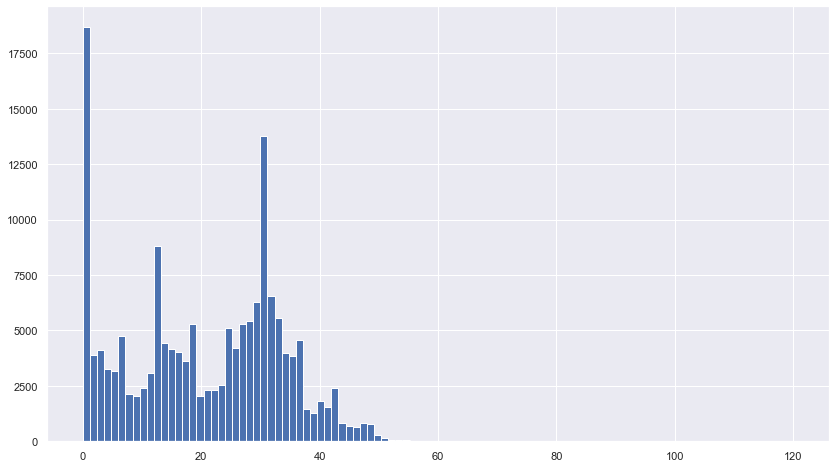

In [31]:
plt.figure(figsize=(14,8))
plt.hist(df_all['how_old'], bins=100)
plt.show()

### 敷金・礼金
敷金・礼金をそのまま使うとデータリークするため、金額が記載されている場合は、何か月分の家賃かに置換する。

In [32]:
df_all['key_money'] = df_all['security_deposit'].apply(lambda x: x.split(' / ')[1])
df_all['security_deposit'] = df_all['security_deposit'].apply(lambda x: x.split(' / ')[0])

In [33]:
def preprocess_security_deposit(row):
    if 'ヶ月' in row['security_deposit']:
        # 正規表現で小数点を含む数字を取得
        how_months = float(re.findall('(\d*[.,]?\d*)ヶ月', row['security_deposit'])[0])
    elif '万円' in row['security_deposit']:
        money = float(re.findall('(\d*[.,]?\d*)万円', row['security_deposit'])[0])*10000
        how_months = money/row['rent']
    elif '無'== row['security_deposit']:
        how_months = 0
    else:
        raise Exception
    return how_months

def preprocess_key_money(row):
    if 'ヶ月' in row['key_money']:
        how_months = float(re.findall('(\d*[.,]?\d*)ヶ月', row['key_money'])[0])
    elif '万円' in row['key_money']:
        money = float(re.findall('(\d*[.,]?\d*)万円', row['key_money'])[0])*10000
        how_months = money/row['rent']
    elif '無'== row['key_money']:
        how_months = 0
    else:
        raise Exception
    return how_months

df_all['security_deposit'] = df_all.apply(preprocess_security_deposit, axis=1)
df_all['key_money'] = df_all.apply(preprocess_key_money, axis=1)

### 更新料

In [34]:
def preprocess_renewal_fee(row):
    # nanを含んでいる場合、文字型でないとエラーがでる。
    if 'ヶ月' in str(row['renewal_fee']):
        how_months = float(re.findall('新賃料の(\d*[.,]?\d*)ヶ月分', row['renewal_fee'])[0])
    elif '円' in str(row['renewal_fee']):
        money = float(re.sub(',|円', '', row['renewal_fee']))
        how_months = money/row['rent']
    else:
        how_months = 0
    return how_months

df_all['renewal_fee'] = df_all.apply(preprocess_renewal_fee, axis=1)

### 最寄り駅までの時間

In [35]:
df_all['time_to_go_nearest_station'] = \
        df_all['traffic'].apply(lambda x: re.findall('徒歩(\d+)分', x)[0] if '徒歩' in x else None).astype('float')

### 階数

301階なるものが存在しますが、中国で構想段階の300階建てのビル（1228m）に匹敵する高さなので明らかに間違いです笑  
3階になおしておきます。

In [36]:
df_all[df_all['name']=='ロイヤルコートＫａｙＡＢ'].floor

38283    301階/B206
Name: floor, dtype: object

In [37]:
df_all.loc[df_all[df_all['name']=='ロイヤルコートＫａｙＡＢ'].index, 'floor'] = '3階'

In [38]:
df_all[['floor2','floor']]

,floor2,floor
0,4階 / 4階建\n,4階/401
1,2階 / 12階建\n,2階/-
2,3階 / 12階建\n,3階/-
3,2階 / 3階建\n,2階/205
4,2階 / 3階建\n,2階/201
...,...,...
164680,4階 / 9階建\n,4階/-
164681,2階 / 9階建\n,2階/-
164682,1階 / 2階建\n,1階/-
164683,2階 / 2階建\n,NaN


In [39]:
def extract_max_foor(row):
    try:
        if '階' in str(row):
            max_floor = re.findall('(\d+)階', row)[1]
        else:
            max_floor = None
    except:
        max_floor = None
    return max_floor

In [40]:
df_all['max_floor'] = df_all['floor2'].apply(extract_max_foor).astype('float')

In [41]:
df_all['floor'] = df_all['floor2'].apply(lambda x: re.findall('(\d+)階', x)[0] if '階' in str(x) else 0).astype('int')

In [42]:
df_all.drop(['rent', 'service_fee'], axis=1, inplace=True)

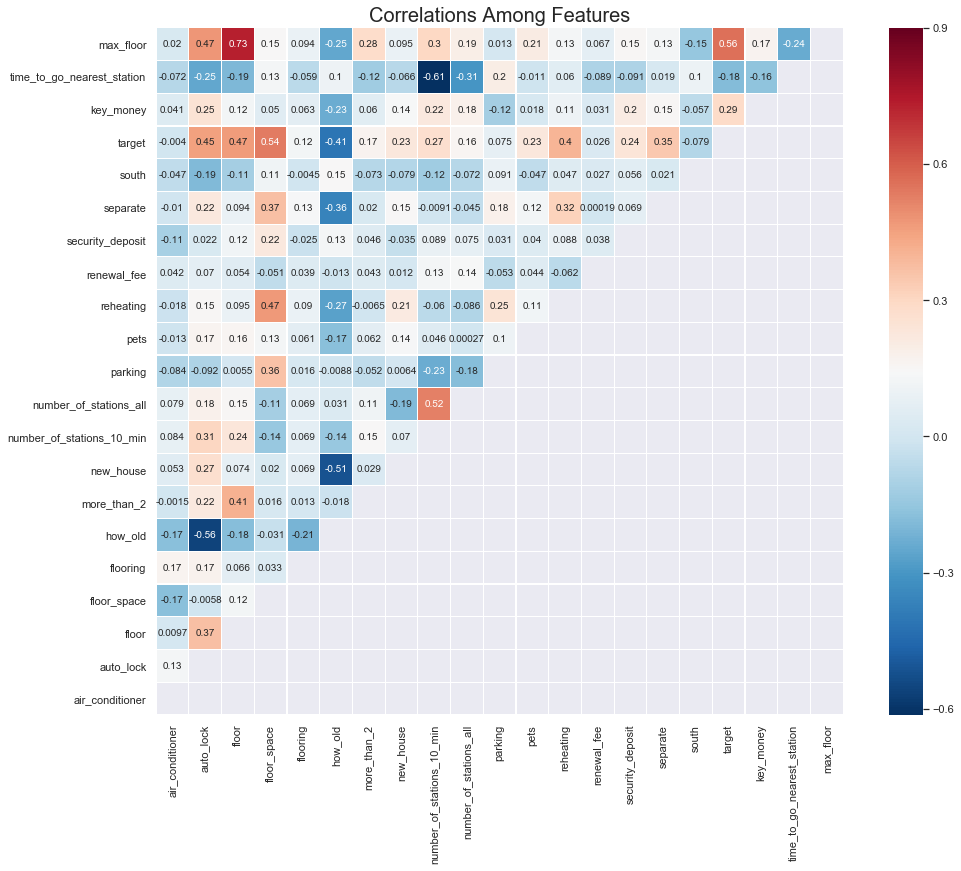

In [43]:
mask = np.zeros_like(df_all.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (15,12))
sns.heatmap(df_all.corr(), 
            annot=True,
            mask = mask,
            cmap = 'RdBu_r',
            linewidths=0.1, 
            linecolor='white',
            vmax = .9,
            square=True)
plt.title("Correlations Among Features", y = 1.03,fontsize = 20)
plt.tight_layout()
plt.ylim(0,len(df_all.corr()))
plt.show()

### ヒートマップからわかること
- `auto_lock`と家賃の相関がかなり大きい。ただし、`auto_lock`は築年数と大きな負の相関があり、これは`auto_lock`が導入され始めたのが比較的新しいためだと考えられる。  
したがって、家賃とオートロックは疑似相関（築年数を介した）の可能性が高い

### 間取り
|アルファベット  |意味  |
|---|---|
|R  |一般的に1部屋の中にキッチンが含まれている間取り  |
|K  |居室とキッチンの間に間仕切りがある間取り  |
|D  |キッチンで食事がとれるようなスペースがある  |
|L  |食事やテレビを見たりできるようなダイニングよりもさらに広いスペースがある  |
|S  |サービスルームの略。採光が不足し居室とは認められないがフリースペースとして使える部屋  |

参考：https://suumo.jp/yougo/m/madori/

In [44]:
df_all['floor_plan'] = df_all['floor_plan'].apply(lambda x: x.split()[0])

In [45]:
df_all['floor_plan'].unique()

array(['ワンルーム', '1K', '1LDK', '1DK', '3LDK', '2K', '2LDK', '2DK', '2SLDK',
       '1SK', '1SLDK', '3DK', '1SDK', '1SLK', '3K', '2SDK', '1LK',
       '3SLDK', '4DK', '4LDK', '4SLDK', '3SDK', '10K', '2LK', '5SLDK',
       '5DK', '2R', '4K', '2SLK', '5K', '2SK', '5LDK', '3LK', '6R', '15K',
       '3SK', '5SK', '4SDK', '11K', '8LDK', '6LDK', '7LDK', '5SDK',
       '6SLDK', '3SLK', '6DK', '12DK', '7SLDK', '4SK'], dtype=object)

### 住所

In [46]:
df_all['address_town'] = df_all['address'].apply(lambda x: re.split('\d+', x)[0])

In [47]:
numeric_col = [s for s in df_all.columns if df_all[s].dtype != 'object']
object_col = ['floor_plan', 'first_near_station', 'second_near_station', 'third_near_station', 'status', 'address', 'address_town', 'name', 'url', 'structure']

In [48]:
df = df_all[numeric_col + object_col]

In [49]:
df['target'] = np.log1p(df['target'].copy())

/Users/KobayashiYosuke/.local/share/virtualenvs/Tokyo-house-price-prediction-wXlIqgjE/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


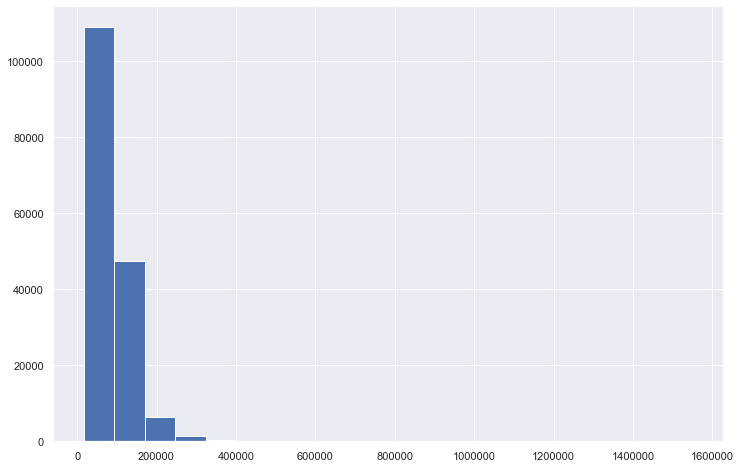

In [50]:
plt.figure(figsize=(12, 8))
plt.hist(np.ceil(df_all['target']), bins=20)
plt.show()

In [51]:
from sklearn.preprocessing import LabelEncoder

encoder_dict = {}
for col in object_col:
    if col != 'url':
        df[col].fillna('-999', inplace=True)
        encoder_dict[col] = LabelEncoder().fit(df[col])
        df[col] = encoder_dict[col].transform(df[col].copy())

/Users/KobayashiYosuke/.local/share/virtualenvs/Tokyo-house-price-prediction-wXlIqgjE/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/Users/KobayashiYosuke/.local/share/virtualenvs/Tokyo-house-price-prediction-wXlIqgjE/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# 機械学習モデルの作成
---

In [52]:
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

X = df.drop('target', axis=1)
y = df['target'].values
for train_idx, test_idx in gss.split(X, y, groups=X['name'].values):
    X_train, y_train = X.iloc[train_idx], y[train_idx]
    X_test, y_test = X.iloc[test_idx], y[test_idx]    

In [53]:
# from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
nfold = 3
# folds = KFold(n_splits=nfold, shuffle=True, random_state=42)
folds = GroupKFold(n_splits=nfold)
groups = X_train['name'].values
print('-'*20)
print(str(nfold) + ' Folds training...')
print('-'*20)

--------------------
3 Folds training...
--------------------


In [54]:
params_lgb = {
    "boosting": "gbdt",
    "verbosity": -1,
    "num_leaves": 200,
#     "min_data_in_leaf": 10,
    "min_child_weight": 1,
    "max_depth": 8,
    "colsample_bytree": 1.0,
    "subsample": 0.9,
    "gamma": 0,
    "lambda_l2": 1,
    "lambda_l1": 0,
    "learning_rate": 0.1,
    "random_seed": 42,
    "metric": "rmse",
}

In [55]:
%%time
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

oof = np.zeros(len(X_train))
feature_importance_df = pd.DataFrame()
df_fold_all = pd.DataFrame()
tr_rmse = []
val_rmse = []
models = []

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train, groups)):
    strLog = f"fold {fold_}"
    print(strLog)
    df_fold_id = pd.DataFrame(data={'index':val_idx})
    df_fold_id['folds'] = fold_
    df_fold_all = pd.concat([df_fold_all, df_fold_id])
    
    X_tr, X_val = X_train.drop(['url', 'name'], axis=1).iloc[trn_idx], X_train.drop(['url', 'name'], axis=1).iloc[val_idx]
    y_tr, y_val = y_train[trn_idx], y_train[val_idx]
    
    model = lgb.LGBMRegressor(**params_lgb, n_estimators = 100000, n_jobs = -1)
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_tr, y_tr), (X_val, y_val)], 
              eval_metric='rmse',
              verbose=500, 
              early_stopping_rounds=500,
             )

    oof[val_idx] = model.predict(X_val)
    val_score = np.sqrt(mean_squared_error(y_val, oof[val_idx]))
    val_rmse.append(val_score)
    tr_score = np.sqrt(mean_squared_error(y_tr, model.predict(X_tr)))
    tr_rmse.append(tr_score)
    models.append(model)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_tr.columns
    fold_importance_df["importance"] = model.booster_.feature_importance(importance_type='gain')[:len(X_tr.columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

rmse = np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(oof)))
df_fold_all.set_index('index', inplace=True)
print(f'RMSE {rmse}円')

/Users/KobayashiYosuke/.local/share/virtualenvs/Tokyo-house-price-prediction-wXlIqgjE/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


fold 0
Training until validation scores don't improve for 500 rounds
[500]	training's rmse: 0.0631679	valid_1's rmse: 0.0994069
[1000]	training's rmse: 0.0493903	valid_1's rmse: 0.0966779
[1500]	training's rmse: 0.0408242	valid_1's rmse: 0.0956802
[2000]	training's rmse: 0.0347755	valid_1's rmse: 0.0951268
[2500]	training's rmse: 0.0299788	valid_1's rmse: 0.0947458
[3000]	training's rmse: 0.0262723	valid_1's rmse: 0.0945453
[3500]	training's rmse: 0.0232082	valid_1's rmse: 0.0943761
[4000]	training's rmse: 0.0208753	valid_1's rmse: 0.094286
[4500]	training's rmse: 0.0188477	valid_1's rmse: 0.0942086
[5000]	training's rmse: 0.0172252	valid_1's rmse: 0.0941509
[5500]	training's rmse: 0.0157543	valid_1's rmse: 0.094122
[6000]	training's rmse: 0.0145479	valid_1's rmse: 0.0941064
[6500]	training's rmse: 0.0134946	valid_1's rmse: 0.0940936
Early stopping, best iteration is:
[6491]	training's rmse: 0.0135106	valid_1's rmse: 0.0940901
fold 1
Training until validation scores don't improve for 5

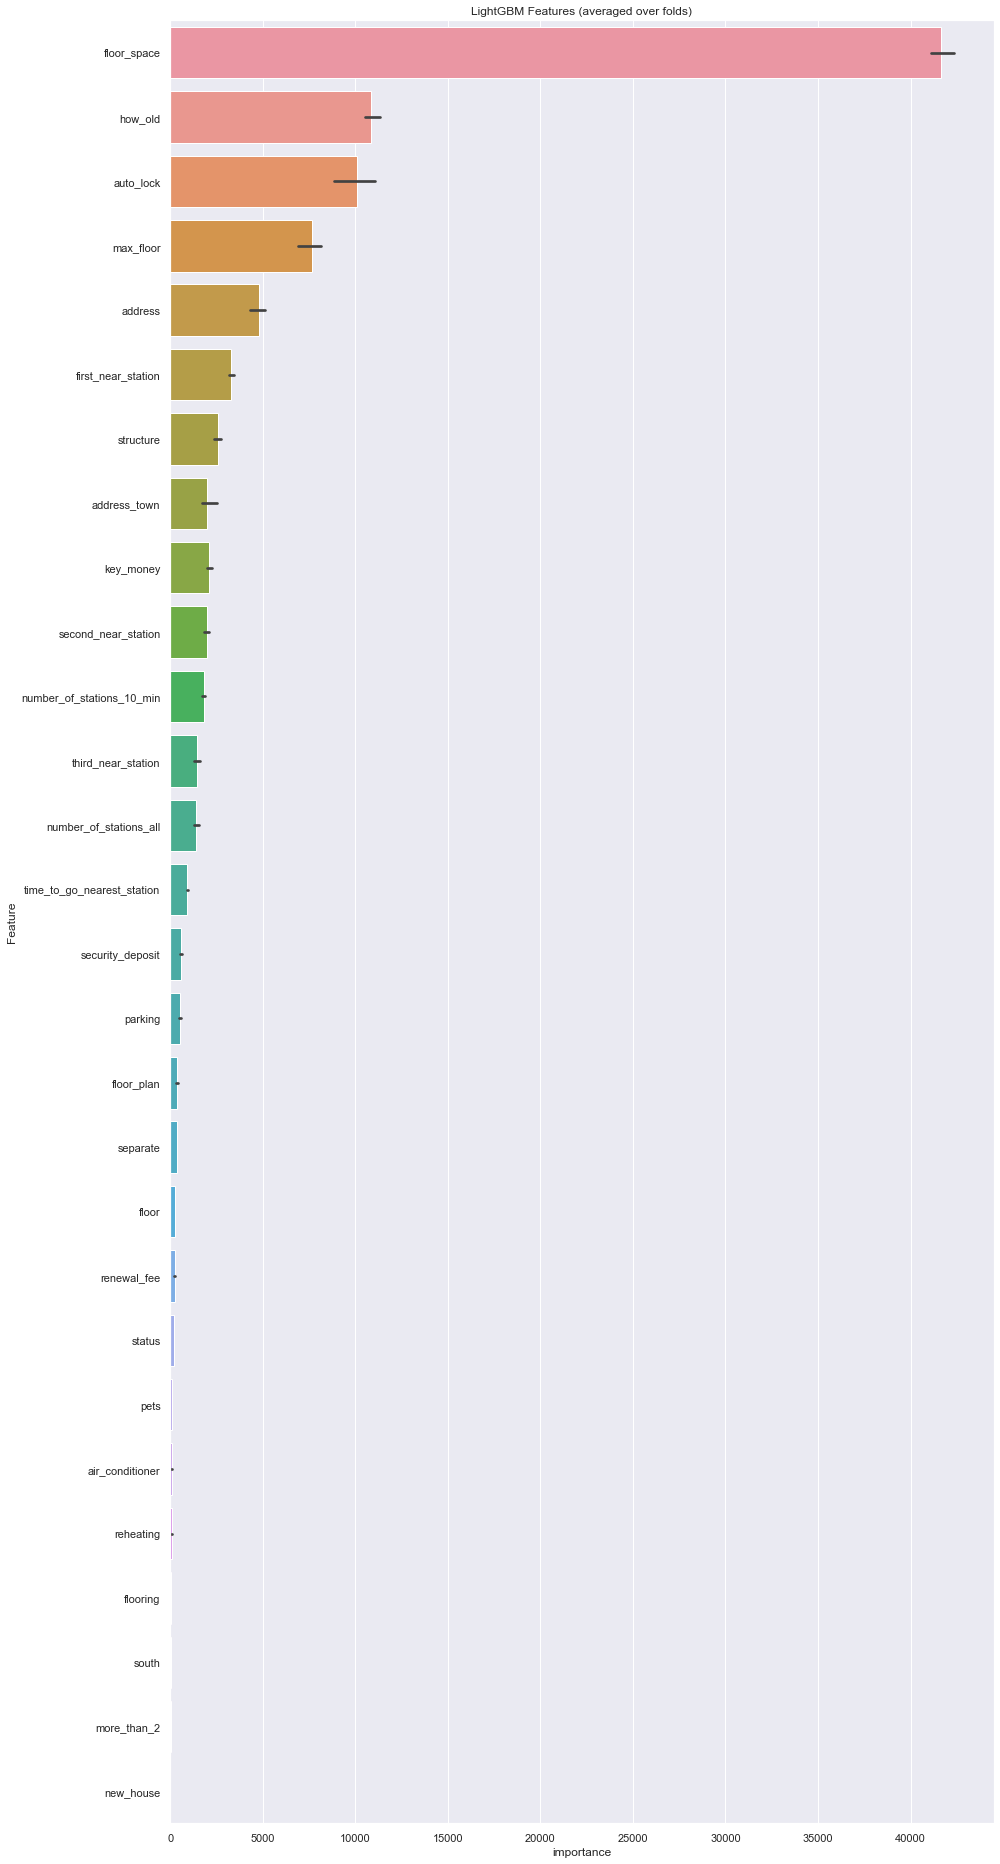

In [56]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:50].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()

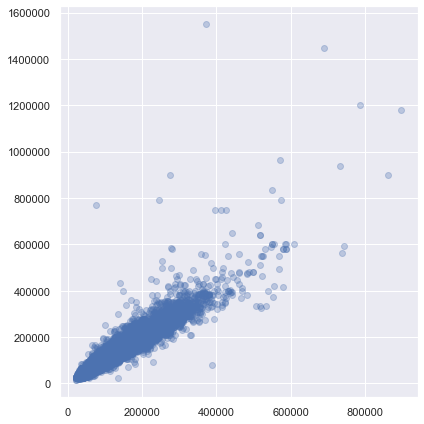

In [57]:
plt.figure(figsize=(6,6))
plt.scatter(np.expm1(oof), np.expm1(y_train), alpha=0.3)
plt.tight_layout()
plt.show()

In [58]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## 相対誤差

In [59]:
mean_absolute_percentage_error(np.expm1(y_train), np.expm1(oof))

6.453968417481605

In [60]:
def calc_sc(x):
    return np.round_(50+10*(x-np.average(x))/np.std(x))

In [61]:
if model_save:
    for idx, model in enumerate(models):
        model.booster_.save_model(f'../data/lgb_regressor_{idx}.txt')
    X_train = X_train.reset_index(drop=True).join(df_fold_all)
    X_train['target'] = np.expm1(y_train)
    X_train['predict'] = np.expm1(oof)
    X_train['mape'] = X_train.apply(lambda x: (x['predict']-x['target'])/x['target'], axis=1)
    X_train['sc'] = calc_sc(X_train['mape'])
    X_train.to_csv('../data/x_train.csv', index=False)

In [62]:
!jupyter nbconvert --to markdown 不動産価格予測.ipynb
!mv 不動産価格予測.md README.md

[NbConvertApp] Converting notebook 不動産価格予測.ipynb to markdown
[NbConvertApp] Support files will be in 不動産価格予測_files/
[NbConvertApp] Making directory 不動産価格予測_files
[NbConvertApp] Making directory 不動産価格予測_files
[NbConvertApp] Making directory 不動産価格予測_files
[NbConvertApp] Making directory 不動産価格予測_files
[NbConvertApp] Making directory 不動産価格予測_files
[NbConvertApp] Making directory 不動産価格予測_files
[NbConvertApp] Making directory 不動産価格予測_files
[NbConvertApp] Making directory 不動産価格予測_files
[NbConvertApp] Making directory 不動産価格予測_files
[NbConvertApp] Making directory 不動産価格予測_files
[NbConvertApp] Making directory 不動産価格予測_files
[NbConvertApp] Writing 36637 bytes to 不動産価格予測.md
